In [4]:
import math
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 绘图
import matplotlib.pyplot as plt
import numpy as np
# 读取数据
import gzip
import csv

from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

# ------------0 parameters-------------#
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 100
N_CHARS = 128  # 字典长度
USE_GPU = True  # 不用GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/sentiment.model2"

In [ ]:
csv.register_dialect('mydialect',delimiter='\t',quoting=csv.QUOTE_ALL)
filename='sentiment/train.tsv/mytest.tsv'
with open(filename,'rt') as f:
    reader = csv.reader(f,'mydialect')
    rows1 = list(reader)
    del rows1[0]
print(rows1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
csv.register_dialect('mydialect',delimiter='\t',quoting=csv.QUOTE_ALL)
filename='sentiment/train.tsv/train.tsv'
with open(filename,'rt') as f:
    reader = csv.reader(f,'mydialect')
    rows2 = list(reader)
    del rows2[0]

In [ ]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'sentiment/train.tsv/train2.tsv' if is_train_set else 'sentiment/train.tsv/mytest2.tsv'


        with open(filename,'rt') as f:
            reader = csv.reader(f,'mydialect')
            rows = list(reader)
            del rows[0]
        self.PhraseId = [row[0] for row in rows]
        self.SentenceId = [row[1] for row in rows]
        self.Phrase = [row[2] for row in rows]
        self.Sentiment = [int(row[3]) for row in rows]

        self.len = len(self.PhraseId)
 
        self.Sent_list = list(sorted(set(self.Sentiment)))  # set:去除重复，sorted：排序，list：转换为列表

        self.Sent_num = len(self.Sent_list)

    def __getitem__(self, index):
        return self.Phrase[index], self.Sentiment[index]
        # 取出的Phraseh是字符串，Sentiment是索引

    def __len__(self):
        return self.len


    def getSent_num(self):  
        return self.Sent_num


In [ ]:
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
N_SENT = trainset.getSent_num()

In [ ]:
testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def name2list(name):
    arr = [ord(c) for c in name]  # 返回对应字符的 ASCII 数值
    return arr, len(arr)  # 返回元组，列表本身和列表长度

In [ ]:
# sequences_and_lengths = [name2list(name) for name in Phrase]
# name_sequences = [sl[0] for sl in sequences_and_lengths]
# print(name_sequences[:10])

In [ ]:

def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_sequences = [sl[0] for sl in sequences_and_lengths]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequences_and_lengths])
    countries = countries.long()  # countries

    # make tensor of name, BatchSize x SeqLen
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    # 先制作一个全0的tensor，然后将名字贴在上面

    # 排序，sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    # sort返回两个值，seq_lengths：排完序后的序列（未padding），perm_idx：排完序后对应元素的索引
    seq_tensor = seq_tensor[perm_idx]  # 排序（已padding）
    countries = countries[perm_idx]  # 排序（标签）
    return create_tensor(seq_tensor), seq_lengths, create_tensor(countries)


In [ ]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1  # bidirectional，双向循环神经网络
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)
        #gru的bidirectional参数会得到hidden_size*self的形状矩阵

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)
        return create_tensor(hidden)
    def forward(self, input, seq_lengths):
        input = input.t()  # 转置 t -> transpose: input shape : B x S -> S x B
        batch_size = input.size(1)

        hidden = self._init_hidden(batch_size)  # h0
        embedding = self.embedding(input)  # （seqLen,batchSize,hiddenSize)

        # PackedSquence：把为0的填充量去除，把每个样本的长度记录下来，按长度排序后拼接在一起
        gru_input = pack_padded_sequence(embedding, seq_lengths)

        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions == 2:  # 双向循环神经网络有两个hidden
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]

        fc_output = self.fc(hidden_cat)
        return fc_output


classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_SENT, N_LAYER)
#classifier.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def create_tensor(tensor):
    if USE_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
all_losses=[]
def trainModel():
    pre_total_loss=1000
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        
        inputs, seq_lengths, target = make_tensors(names, countries)  # make_tensors
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i%10==0:
          print(f'[{time_since(start)}] Epoch {epoch} ', end='')
          print(f'[{i * len(inputs)}/{len(trainset)}] ', end='')
          print(f'loss={total_loss / (i * len(inputs))}')
          all_losses.append(total_loss / (i * len(inputs)))
        if i%70==0:
          torch.save(classifier.state_dict(),path)
    return total_loss


In [ ]:
def plot_confusion(confusion):
  # confusion = torch.zeros(5,5)
  # for t, p in zip(predict.view(-1), target.view(-1)):
  #   confusion[t, p] += 1
  # Normalize by dividing every row by its sum
  for i in range(5):
    confusion[i] = confusion[i] / confusion[i].sum()
  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # # Set up axes
  # ax.set_xticklabels([''] + all_categories, rotation=90)
  # ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

In [ ]:
def testModel():
    correct = 0
    confusion = torch.zeros(5,5)
    total = len(testset)
    print("evaluating trained model ...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)  # make_tensors
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            for t, p in zip(pred.view(-1), target.view(-1)):
              confusion[t, p] += 1

            correct += pred.eq(target.view_as(pred)).sum().item()
        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')
        print(f'Test set: 平均F1 {F1(confusion)[3]}')
        print(f'Test set: precision {F1(confusion)[0]}')
        print(f'Test set: recall {F1(confusion)[1]}')
        print(f'Test set: F1 {F1(confusion)[2]}')



        
        plot_confusion(confusion)
    return correct / total


In [ ]:
class NameDatasetKaggel(Dataset):
    def __init__(self, is_train_set=True):
        filename = 'sentiment/train.tsv/train.tsv' if is_train_set else 'sentiment/train.tsv/test.tsv'


        with open(filename,'rt') as f:
            reader = csv.reader(f,'mydialect')
            rows = list(reader)
            del rows[0]
        self.PhraseId = [row[0] for row in rows]
        self.SentenceId = [row[1] for row in rows]
        self.Phrase = [row[2] for row in rows]
#         self.Sentiment = [int(row[3]) for row in rows]

        self.len = len(self.PhraseId)

#       self.Sent_list = list(sorted(set(self.Sentiment)))  # set:去除重复，sorted：排序，list：转换为列表

        # self.Sent_num = len(self.Sent_list)

    def __getitem__(self, index):
        return self.Phrase[index]
        # 取出的Phraseh是字符串，Sentiment是索引

    def __len__(self):
        return self.len


    def getSent_num(self):  # Return the number of countries.
        return self.Sent_num
    
testsetKaggle = NameDatasetKaggel(is_train_set=False)
testloaderKaggle = DataLoader(testsetKaggle, batch_size=BATCH_SIZE, shuffle=False)
def testModelKaggle():
    predKaggle=[]
    print("尝试生成提交数据 ...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloaderKaggle, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)  # make_tensors
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            predKaggle.append(pred)
    return predKaggle


In [ ]:
def F1(confusion):
  precision=[]
  recall=[]
  f1=[]
  for i in range(5):
    precision.append(confusion[i][i]/confusion[i].sum())
    recall.append(confusion.T[i][i]/confusion.T[i].sum())
  precision=np.array(precision)
  recall=np.array(recall)
  f1=2*precision*recall/(precision+recall)
  return precision,recall,f1,np.average(f1)

cddd=torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]).numpy()
F1(cddd)

(array([0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333]),
 array([0.2, 0.2, 0.2, 0.2, 0.2]),
 array([0.1       , 0.16      , 0.2       , 0.22857143, 0.25      ]),
 0.18771428571428572)

In [ ]:
if __name__ == '__main__':
    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)
    start = time.time()
    
    for epoch in range(1,200):
         trainModel()
         # torch.save(classifier.state_dict(),path)
         #testModel()

流式输出内容被截断，只能显示最后 5000 行内容。
 52s] Epoch 18 [38400/136155] loss=0.00032868280706073466
 53s] Epoch 18 [40960/136155] loss=0.00032551574477110987
 53s] Epoch 18 [43520/136155] loss=0.0003262019039967152
 54s] Epoch 18 [46080/136155] loss=0.0003242358689021785
 54s] Epoch 18 [48640/136155] loss=0.0003278850190997075
 54s] Epoch 18 [51200/136155] loss=0.0003261784619098762
 55s] Epoch 18 [53760/136155] loss=0.00032479980041638814
 55s] Epoch 18 [56320/136155] loss=0.0003241723804835188
 56s] Epoch 18 [58880/136155] loss=0.0003234726459714179
 56s] Epoch 18 [61440/136155] loss=0.00032338476473038705
 57s] Epoch 18 [64000/136155] loss=0.0003241758024669252
 57s] Epoch 18 [66560/136155] loss=0.00032653849031283663
 58s] Epoch 18 [69120/136155] loss=0.0003271061540645961
 58s] Epoch 18 [71680/136155] loss=0.0003280814637296966
 59s] Epoch 18 [74240/136155] loss=0.0003303858658282793
 59s] Epoch 18 [76800/136155] loss=0.0003335190992220305
 59s] Epoch 18 [79360/136155] loss=0.0003355471352058943

KeyboardInterrupt: ignored

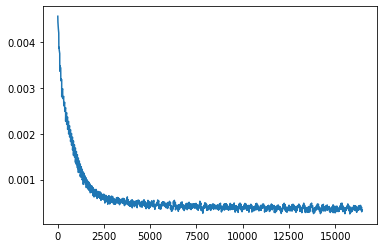

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
len(all_losses)

16462

evaluating trained model ...
Test set: Accuracy 62776/69663 90.11%
Test set: 平均F1 0.8783755302429199
Test set: precision [0.892624   0.87605655 0.92743564 0.8643087  0.8936116 ]
Test set: recall [0.8137459  0.874422   0.9345066  0.88561803 0.8278708 ]
Test set: F1 [0.8513619  0.87523854 0.9309577  0.8748336  0.8594859 ]


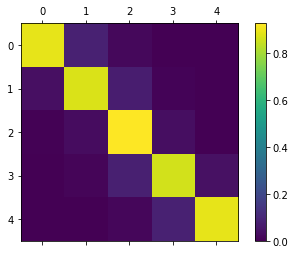

In [ ]:
if __name__ == '__main__':
    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)
        testModel()

In [6]:

def save_loss(file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        # writer.writerow(['PhraseId', 'Sentiment'])
        for i in all_losses:
          writer.writerow([i])
            

save_loss('/content/drive/MyDrive/loss2.csv')  

Saving results to /content/drive/MyDrive/loss2.csv
